<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/feat%2Floading-dataset/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

### Download Dataset

In [ ]:
!git clone https://github.com/sam-single/realwaste.git

### Dataset Class

In [19]:
class RealWasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')): # Add more image extensions if needed
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = read_image(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Visualize Data

In [20]:
dataset_path = '/content/realwaste/RealWaste'
realwaste_dataset = RealWasteDataset(dataset_path)
print(f"Number of images in the dataset: {len(realwaste_dataset)}")
print(f"Classes: {realwaste_dataset.classes}")
first_image, first_label = realwaste_dataset[0]
print(f"First image shape: {first_image.shape}")
print(f"First image label: {first_label}")

Number of images in the dataset: 4752
First image shape: torch.Size([3, 524, 524])
First image label: 0
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


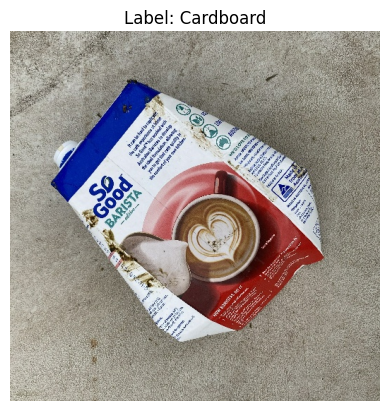

In [22]:
def plot_image(image, label):
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {realwaste_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# Get the first image and label from the dataset
first_image, first_label = realwaste_dataset[0]
plot_image(first_image, first_label)

### Split Dataset

In [31]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

def split_dataset(
    dataset: Dataset,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float
):
    # Define the split ratios
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15

    # Get the labels for stratification
    all_labels = np.array(realwaste_dataset.labels)

    # Perform stratified split for train and the rest (val + test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_indices, rest_indices = next(sss.split(np.zeros(len(all_labels)), all_labels))

    # Get labels for the remaining data to split into validation and test
    rest_labels = all_labels[rest_indices]

    # Perform stratified split for validation and test
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    val_indices, test_indices = next(sss_val_test.split(np.zeros(len(rest_labels)), rest_labels))

    # Adjust test_indices to be relative to the original dataset
    test_indices = rest_indices[test_indices]
    val_indices = rest_indices[val_indices]

    # Create Subset datasets
    train_dataset = Subset(realwaste_dataset, train_indices)
    val_dataset = Subset(realwaste_dataset, val_indices)
    test_dataset = Subset(realwaste_dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(
    realwaste_dataset, 0.7, 0.15, 0.15)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3326
Validation set size: 713
Test set size: 713


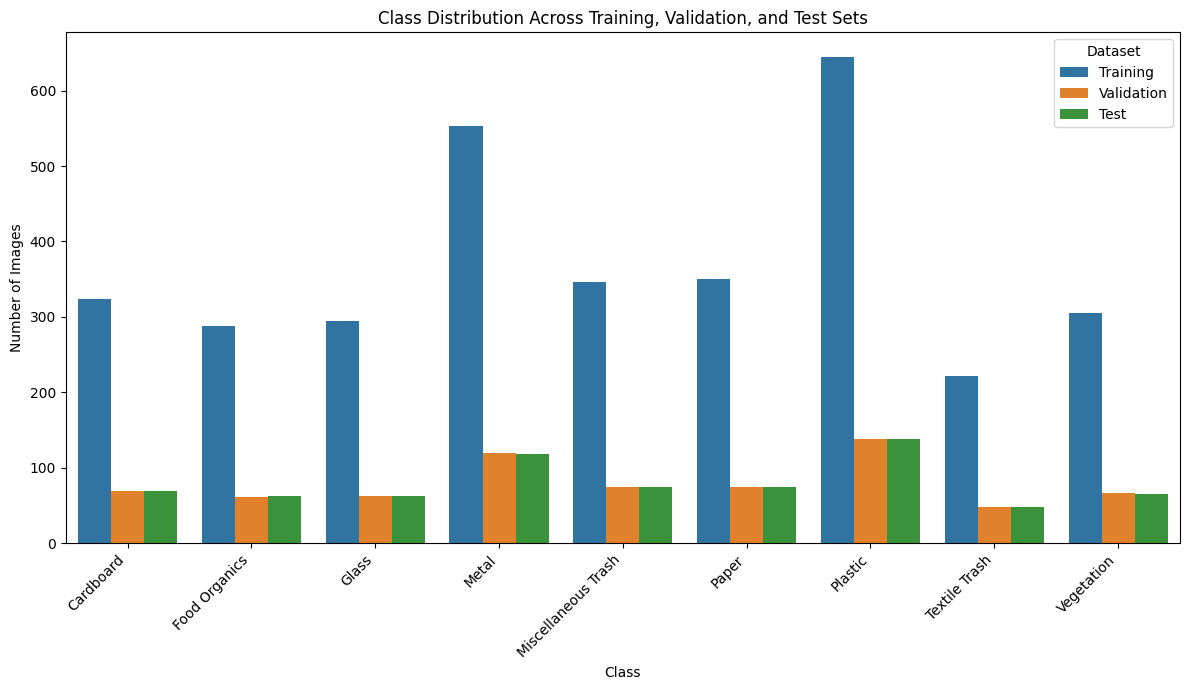

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def get_class_counts_df(dataset, dataset_name, classes):
    labels = [realwaste_dataset.labels[i] for i in dataset.indices]
    class_counts = np.bincount(labels, minlength=len(classes))
    df = pd.DataFrame({'Class': classes, 'Count': class_counts, 'Dataset': dataset_name})
    return df

# Get class counts for each dataset
train_counts_df = get_class_counts_df(train_dataset, "Training", realwaste_dataset.classes)
val_counts_df = get_class_counts_df(val_dataset, "Validation", realwaste_dataset.classes)
test_counts_df = get_class_counts_df(test_dataset, "Test", realwaste_dataset.classes)

# Concatenate the dataframes
all_counts_df = pd.concat([train_counts_df, val_counts_df, test_counts_df])

# Plot the combined chart
plt.figure(figsize=(12, 7))
sns.barplot(data=all_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution Across Training, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()